<a href="https://colab.research.google.com/github/ravi-gopalan/DAND_Data_Wrangling/blob/master/reviews_LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [2]:
cd '/gdrive/My Drive/abv_reviews'

/gdrive/My Drive/abv_reviews


In [4]:
!pip install emot
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 3.5MB/s 
     |████████████████████████████████| 552kB 50.9MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=1f434b6ae635f7f0a0c4cda64f4602c94f28b4403233d9347112ed98ebb4f163
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32040 sha256=8f981a2533168dae573282c97d793f3bfb2f40443e2a13acedda345674ea8fab
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


In [0]:
import pandas as pd
import numpy as np
import random
import json
from tqdm import tqdm
from collections import Counter,OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns
import re

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [6]:
# import logging
import pyLDAvis.gensim
from gensim.models.coherencemodel import CoherenceModel

import warnings
warnings.filterwarnings('ignore')

import spacy

from gensim import models,corpora
from gensim.summarization import summarize,keywords

/usr/local/lib/python3.6/dist-packages/_pytest/mark/structures.py:426: DeprecationWarning: The usage of `cmp` is deprecated and will be removed on or after 2021-06-01.  Please use `eq` and `order` instead.
  @attr.s(cmp=False, hash=False)
/usr/local/lib/python3.6/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [0]:
from emot.emo_unicode import UNICODE_EMO, EMOTICONS
from bs4 import BeautifulSoup



from textblob import TextBlob

In [15]:
df_review = pd.read_csv('reviews_text.csv')
review_text = df_review[['text']]
review_text.head()

,text
0,Burger joint offers a wide range of cheeseburg...
1,It was really good. The mushroom broth was esp...
2,"$8.90 for sesame rice, mushroom rendang, curry..."
3,2 mains + 1 green rice bento from greendot. Re...
4,The lion mane mushroom rendang is so delicious...


In [16]:
review_text[review_text.text.isnull()]

,text
5052,NaN


In [17]:
df_review.drop(labels=5052,axis=0,inplace=True)
review_text = df_review[['text']]
review_text[review_text.text.isnull()]

,text


In [0]:

# Converting emojis to words
def convert_emojis(text):
    for emot in UNICODE_EMO:
        text = text.replace(emot, "_".join(UNICODE_EMO[emot].replace(",","").replace(":","").split()))
        return text
# Converting emoticons to words    
def convert_emoticons(text):
    for emot in EMOTICONS:
        text = re.sub(u'('+emot+')', "_".join(EMOTICONS[emot].replace(",","").split()), text)
        return text

# Function for url's
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

#Function for removing html

def remove_html_tag(text):
    return BeautifulSoup(text, "lxml").text

# Function for hashtags
def remove_hashtags(text):
    hashtag_pattern = re.compile(r'\#[a-z0-9]+')
    return hashtag_pattern.sub(r'', text)

In [0]:
nlp = spacy.load('en')

In [0]:
def clean_up_spacy(text):
    removal= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE']
    text_out = []
    doc= nlp(text)
    for token in doc:
        if token.is_stop == False and token.is_alpha and len(token)>2 and token.pos_ not in removal:
            lemma = token.lemma_
            text_out.append(lemma)
    return text_out

In [18]:
review_text.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56155 entries, 0 to 56155
Data columns (total 1 columns):
text    56155 non-null object
dtypes: object(1)
memory usage: 877.4+ KB


In [90]:
type(datalist)

pandas.core.series.Series

In [0]:
datalist = review_text.text.apply(lambda x:remove_html_tag(x)).to_frame()


In [22]:
datalist.text.apply(lambda x:remove_urls(x)).to_frame()

,text
0,Burger joint offers a wide range of cheeseburg...
1,It was really good. The mushroom broth was esp...
2,"$8.90 for sesame rice, mushroom rendang, curry..."
3,2 mains + 1 green rice bento from greendot. Re...
4,The lion mane mushroom rendang is so delicious...
...,...
56151,Good love office treats! These are perfectly s...
56152,Very tasty! Crisp fresh vegetables with fried ...
56153,Delicious! Creamy coconut milk red curry sauce...
56154,Absolutely delicious! Great if you’re on the r...


In [23]:
datalist.text.apply(lambda x:remove_urls(x)).to_frame()

,text
0,Burger joint offers a wide range of cheeseburg...
1,It was really good. The mushroom broth was esp...
2,"$8.90 for sesame rice, mushroom rendang, curry..."
3,2 mains + 1 green rice bento from greendot. Re...
4,The lion mane mushroom rendang is so delicious...
...,...
56151,Good love office treats! These are perfectly s...
56152,Very tasty! Crisp fresh vegetables with fried ...
56153,Delicious! Creamy coconut milk red curry sauce...
56154,Absolutely delicious! Great if you’re on the r...


In [24]:
datalist.text.apply(lambda x:convert_emoticons(x)).to_frame()

,text
0,Burger joint offers a wide range of cheeseburg...
1,It was really good. The mushroom broth was esp...
2,"$8.90 for sesame rice, mushroom rendang, curry..."
3,2 mains + 1 green rice bento from greendot. Re...
4,The lion mane mushroom rendang is so delicious...
...,...
56151,Good love office treats! These are perfectly s...
56152,Very tasty! Crisp fresh vegetables with fried ...
56153,Delicious! Creamy coconut milk red curry sauce...
56154,Absolutely delicious! Great if you’re on the r...


In [25]:




datalist.text.apply(lambda x:convert_emojis(x)).to_frame()


,text
0,Burger joint offers a wide range of cheeseburg...
1,It was really good. The mushroom broth was esp...
2,"$8.90 for sesame rice, mushroom rendang, curry..."
3,2 mains + 1 green rice bento from greendot. Re...
4,The lion mane mushroom rendang is so delicious...
...,...
56151,Good love office treats! These are perfectly s...
56152,Very tasty! Crisp fresh vegetables with fried ...
56153,Delicious! Creamy coconut milk red curry sauce...
56154,Absolutely delicious! Great if you’re on the r...


In [26]:
datalist.text.apply(lambda x:remove_hashtags(x)).to_frame()

,text
0,Burger joint offers a wide range of cheeseburg...
1,It was really good. The mushroom broth was esp...
2,"$8.90 for sesame rice, mushroom rendang, curry..."
3,2 mains + 1 green rice bento from greendot. Re...
4,The lion mane mushroom rendang is so delicious...
...,...
56151,Good love office treats! These are perfectly s...
56152,Very tasty! Crisp fresh vegetables with fried ...
56153,Delicious! Creamy coconut milk red curry sauce...
56154,Absolutely delicious! Great if you’re on the r...


In [0]:
datalist.to_csv('datalist_corrected.csv')

In [0]:
datalist = datalist.text.apply(lambda x:clean_up_spacy(x))

In [29]:
datalist.head()

0    [Burger, joint, offer, wide, range, cheeseburg...
1    [good, mushroom, broth, soupy, food, general, ...
2    [sesame, rice, mushroom, rendang, curry, potat...
3    [main, green, rice, bento, greendot, recommend...
4    [lion, mane, mushroom, rendang, delicious, ord...
Name: text, dtype: object

In [0]:
dictionary = corpora.Dictionary(datalist)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in datalist]

In [31]:
finalList =[]
for sublist in datalist:
    for item in sublist:
        finalList.append(item)
c =Counter(finalList)
sorted(c.items(), key=lambda x:x[1],reverse=True)[:50]

[('vegan', 17678),
 ('good', 14462),
 ('dish', 9360),
 ('taste', 8638),
 ('delicious', 7387),
 ('love', 7344),
 ('sauce', 7039),
 ('great', 6356),
 ('nice', 4880),
 ('sweet', 4610),
 ('cheese', 4600),
 ('rice', 4288),
 ('tasty', 4200),
 ('option', 4183),
 ('try', 4117),
 ('come', 4040),
 ('food', 4032),
 ('tofu', 3995),
 ('amazing', 3884),
 ('fry', 3877),
 ('like', 3843),
 ('eat', 3768),
 ('veggie', 3723),
 ('burger', 3587),
 ('fresh', 3562),
 ('flavour', 3531),
 ('mushroom', 3484),
 ('con', 3480),
 ('order', 3448),
 ('bit', 3310),
 ('salad', 3296),
 ('menu', 3141),
 ('spicy', 3004),
 ('flavor', 2948),
 ('place', 2934),
 ('serve', 2836),
 ('pizza', 2812),
 ('cream', 2758),
 ('time', 2753),
 ('add', 2637),
 ('restaurant', 2615),
 ('little', 2590),
 ('texture', 2577),
 ('portion', 2485),
 ('get', 2461),
 ('lot', 2456),
 ('meat', 2447),
 ('meal', 2435),
 ('perfect', 2370),
 ('think', 2343)]

In [32]:
Lda = models.LdaMulticore
coherenceList_umass = []
coherenceList_cv = []

lda= Lda(doc_term_matrix, num_topics=25,id2word = dictionary,\
         passes=20,chunksize=4000,random_state=43)

cm = CoherenceModel(model=lda, corpus=doc_term_matrix,\
                    dictionary=dictionary, coherence='u_mass')

coherenceList_umass.append(cm.get_coherence())
cm_cv = CoherenceModel(model=lda, corpus=doc_term_matrix,\
                       texts=datalist, dictionary=dictionary, coherence='c_v')
coherenceList_cv.append(cm_cv.get_coherence())
vis = pyLDAvis.gensim.prepare(lda, doc_term_matrix, dictionary)





NameError: ignored

In [0]:
pyLDAvis.save_html(vis,f'pyLDAvis_25.html')

In [0]:
lda.save('lda')
dictionary.save('dictionary')
corpora.MmCorpus.serialize('doc_term_matrix.mm', doc_term_matrix)

In [0]:
a = lda.show_topics(num_topics=25,formatted=False,num_words=100)
b = lda.top_topics(doc_term_matrix,dictionary=dictionary,topn=100) # This orders the topics in the decreasing order of coherence score



In [0]:
topic2skillb = {}
topic2csb = {}
topic2skilla = {}
topic2csa = {}
num_topics =lda.num_topics
cnt =1

for ws in b:
    wset = set(w[1] for w in ws[0])
    topic2skillb[cnt] = wset
    topic2csb[cnt] = ws[1]
    cnt +=1
cnt = 1
for ws in a:
    wset = set(w[0]for w in ws[1])
    topic2skilla[ws[0]+1] = wset
    topic2csa[cnt] = ws[1]
    cnt +=1

In [108]:
Lda = models.LdaMulticore
coherenceList_umass = []
coherenceList_cv = []
num_topics_list = np.arange(3,30)
for num_topics in tqdm(num_topics_list):
    lda= Lda(doc_term_matrix, num_topics=num_topics,id2word = dictionary, 
             passes=20,chunksize=500,random_state=43)
    cm = CoherenceModel(model=lda, corpus=doc_term_matrix, 
                        dictionary=dictionary, coherence='u_mass')
    coherenceList_umass.append(cm.get_coherence())
    cm_cv = CoherenceModel(model=lda, corpus=doc_term_matrix,
                           texts=datalist, dictionary=dictionary, coherence='c_v')
    coherenceList_cv.append(cm_cv.get_coherence())
    vis = pyLDAvis.gensim.prepare(lda, doc_term_matrix, dictionary)
    pyLDAvis.save_html(vis,f'pyLDAvis_{num_topics}.html')

100%|██████████| 27/27 [1:48:17<00:00, 237.42s/it]


Text(0.5, 1.0, 'Topic coherence')

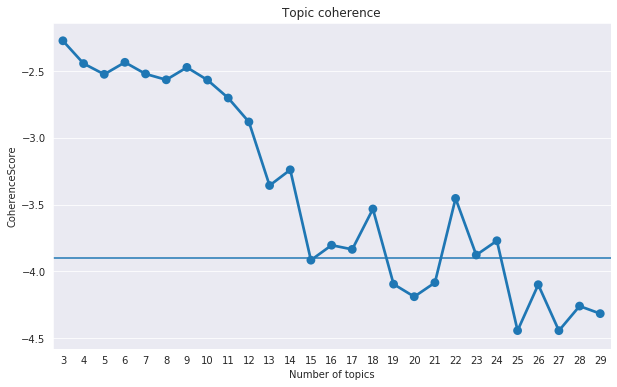

In [112]:

plotData = pd.DataFrame({'Number of topics':num_topics_list,
                         'CoherenceScore':coherenceList_umass})
f,ax = plt.subplots(figsize=(10,6))
sns.set_style("darkgrid")
sns.pointplot(x='Number of topics',y= 'CoherenceScore',data=plotData)
plt.axhline(y=-3.9)
plt.title('Topic coherence')
plt.savefig('Topic coherence plot.png')

In [0]:
Lda = models.LdaMulticore
lda_final= Lda(doc_term_matrix, num_topics=25,id2word = dictionary, passes=20,chunksize=400,random_state=43)

In [0]:
lda_final.save('lda_final')
dictionary.save('dictionary')
corpora.MmCorpus.serialize('doc_term_matrix.mm', doc_term_matrix)

In [52]:
a = lda_final.show_topics(num_topics=25,formatted=False,num_words=100)
b = lda_final.top_topics(doc_term_matrix,dictionary=dictionary,topn=100) # This orders the topics in the decreasing order of coherence score



NameError: ignored

In [37]:
topic2skillb = {}
topic2csb = {}
topic2skilla = {}
topic2csa = {}
num_topics =lda_final.num_topics
cnt =1

for ws in b:
    wset = set(w[1] for w in ws[0])
    topic2skillb[cnt] = wset
    topic2csb[cnt] = ws[1]
    cnt +=1
cnt = 1
for ws in a:
    wset = set(w[0]for w in ws[1])
    topic2skilla[ws[0]+1] = wset
    topic2csa[cnt] = ws[1]
    cnt +=1
 

NameError: ignored

In [0]:
for i in range(1,num_topics+1):
    for j in range(1,num_topics+1):  
        if topic2skilla[i].intersection(topic2skillb[j])==topic2skilla[i]:
            topic2csa[i] = topic2csb[j]

In [56]:

    
finalData = pd.DataFrame([],columns=['Topic','words'])
finalData['Topic']=topic2skilla.keys()
finalData['Topic'] = finalData['Topic'].apply(lambda x: 'Topic'+str(x))
finalData['words']=topic2skilla.values()
finalData['cs'] = topic2csa.values()

finalData.sort_values(by='cs',ascending=False,inplace=True)
finalData.to_csv('CoherenceScore.csv')
finalData


,Topic,words,cs
7,Topic8,"{jaan, bad, version, mock, similar, chicken, s...",-3.826031
21,Topic22,"{excellent, version, small, table, fast, area,...",-4.195993
19,Topic20,"{herb, roasted, dress, top, seed, mix, avo, ov...",-4.329468
2,Topic3,"{year, bad, sure, place, hungry, mean, taste, ...",-4.581100
24,Topic25,"{group, small, sure, chicken, precio, cook, so...",-5.159432
16,Topic17,"{jaan, desert, whip, dense, sugar, top, dairy,...",-5.584490
0,Topic1,"{excellent, jaan, dipping, chicken, wing, ranc...",-6.311987
23,Topic24,"{porque, uno, mejore, frutos, toda, mis, otro,...",-7.019867
8,Topic9,"{plastic, work, small, quick, soup, mix, pumpk...",-7.055661
15,Topic16,"{gourmet, version, sure, pumpkin, pizza, nice,...",-7.541149


In [59]:
finalData['words'][8]

{'Buddha',
 'Lima',
 'Place',
 'big',
 'blend',
 'bowl',
 'bring',
 'broth',
 'building',
 'cheap',
 'cold',
 'come',
 'consider',
 'cost',
 'court',
 'cute',
 'day',
 'delicious',
 'develop',
 'dinner',
 'eat',
 'evening',
 'favourite',
 'feel',
 'fill',
 'filling',
 'floor',
 'food',
 'forget',
 'fresh',
 'good',
 'goodness',
 'great',
 'healthy',
 'hearty',
 'high',
 'hominy',
 'hot',
 'ingredient',
 'know',
 'light',
 'lil',
 'look',
 'lot',
 'love',
 'lovely',
 'lunch',
 'mark',
 'meal',
 'mix',
 'need',
 'newarc',
 'nice',
 'nourishing',
 'nutritious',
 'office',
 'option',
 'organic',
 'pack',
 'perfect',
 'plantbasedjapan',
 'plastic',
 'poke',
 'popolo',
 'porridge',
 'price',
 'pumpkin',
 'quality',
 'quick',
 'recommend',
 'refreshing',
 'salad',
 'satisfying',
 'simple',
 'small',
 'snack',
 'soba',
 'soft',
 'soup',
 'spend',
 'starter',
 'store',
 'summer',
 'super',
 'tamari',
 'taste',
 'tasting',
 'tasty',
 'today',
 'tofu',
 'topping',
 'use',
 'veg',
 'veggie',
 'wan

In [42]:
num_topics =25
vis = pyLDAvis.gensim.prepare(lda, doc_term_matrix, dictionary,sort_topics=False)
pyLDAvis.save_html(vis,f'pyLDAvis_5.html')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.167282 -0.075295       1        1   5.309484
1      0.096684 -0.024167       2        1   3.579478
2      0.155190 -0.040348       3        1   8.113931
3     -0.017780  0.076410       4        1   2.372373
4      0.088729  0.000357       5        1   1.924057
5     -0.123404  0.206617       6        1   1.522813
6     -0.002973  0.083241       7        1   2.573782
7      0.212496 -0.141742       8        1  10.640517
8      0.115707 -0.018497       9        1   4.048420
9      0.092199  0.006386      10        1   2.568470
10    -0.294489 -0.095425      11        1   2.770185
11    -0.107236  0.193953      12        1   1.118181
12     0.100918 -0.036360      13        1   3.318842
13    -0.088409  0.173663      14        1   1.648863
14    -0.003472  0.073264      15        1   2.613398
15     0.133311 -0.023684      16        1   4.1175

In [121]:
num_topics =25
vis = pyLDAvis.gensim.prepare(lda_final, doc_term_matrix, dictionary,sort_topics=False)
pyLDAvis.save_html(vis,f'pyLDAvis_{num_topics}.html')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0      0.100678 -0.153146       1        1  5.095597
1     -0.264049 -0.030068       2        1  1.770805
2      0.155838  0.037616       3        1  7.316247
3     -0.033516  0.052510       4        1  2.362251
4     -0.019049 -0.065368       5        1  2.653512
5     -0.083932 -0.064719       6        1  2.872945
6      0.069926 -0.021238       7        1  3.512070
7     -0.112036  0.000277       8        1  2.498696
8      0.097323  0.000624       9        1  4.561342
9     -0.003010 -0.010894      10        1  3.118087
10     0.035143  0.028936      11        1  4.190141
11    -0.075901  0.168178      12        1  4.245382
12     0.051986  0.095443      13        1  4.850162
13     0.059736  0.057681      14        1  3.883035
14    -0.062618 -0.096820      15        1  2.219912
15    -0.072562  0.052126      16        1  3.165334
16    -0.184437

In [0]:
token_percent = vis.topic_coordinates.sort_values(by='topics').loc[:,['topics','Freq']]

In [0]:
def get_relevant_words(vis,lam=0.3,topn=10):
    a = vis.topic_info
    a['finalscore'] = a['logprob']*lam+(1-lam)*a['loglift']
    a = a.loc[:,['Category','Term','finalscore']].groupby(['Category'])\
    .apply(lambda x: x.sort_values(by='finalscore',ascending=False).head(topn))
    a = a.loc[:,'Term'].reset_index().loc[:,['Category','Term']]
    a = a[a['Category']!='Default']
    a = a.to_dict('split')['data']
    d ={}
    for k,v in a: 
        if k not in d.keys():
            d[k] =set()
            d[k].add(v)
        else:
            d[k].add(v)
    finalData = pd.DataFrame([],columns=['Topic','words with Relevance'])
    finalData['Topic']=d.keys()
    finalData['words with Relevance']=d.values()
    return finalData

In [51]:
finalData['words'][11]

{'food',
 'govegan',
 'low',
 'oil',
 'papa',
 'pasta',
 'vegan',
 'veganlife',
 'vomx',
 'yummy'}

In [45]:
get_relevant_words(vis,0.3).merge(finalData,how='left',on ='Topic').sort_values(by='cs',ascending=False).iloc[:,[0,1]]

,Topic,words with Relevance
14,Topic22,"{place, service, food, option, offer, friendly..."
16,Topic24,"{hay, nada, mis, rojo, gustó, elhogar, pero, e..."
8,Topic17,"{dessert, cake, comida, moist, cookie, donut, ..."
18,Topic3,"{photo, buy, time, eat, friend, year, wait, ta..."
9,Topic18,"{con, papas, sabore, Muy, postre, tomate, frit..."
0,Topic1,"{asher, Burger, Price, patty, burger, fry, bun..."
23,Topic8,"{interesting, taste, texture, little, mock, di..."
17,Topic25,"{yam, brown, tofu, porción, precio, rice, soup..."
12,Topic20,"{falafel, tomato, hummus, pepper, dressing, sa..."
24,Topic9,"{fresh, bowl, lunch, poke, meal, healthy, offi..."
